In [1]:
#Khai báo các thư viện 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model # type: ignore

#Các lớp để xây dựng mô hình
from keras.models import Sequential #Đầu vào 
from keras.layers import LSTM #Học phụ thuộc
from keras.layers import Dropout# Tránh học tủ over fitting
from keras.layers import Dense #Đầu ra

#Kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #Đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #Đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #Đo phần trăm sai số tuyệt đối trung bình 

import json
import time
import import_ipynb
import dd


importing Jupyter notebook from dd.ipynb


In [2]:
import pandas as pd
from kafka import KafkaConsumer
import time
import io

# Thời gian chờ (giây)
timeout_duration = 10

# Tạo Kafka Consumer
consumer = KafkaConsumer(
    "sic_4",
    bootstrap_servers='localhost:9092',
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Danh sách để lưu trữ các tin nhắn
messages = []

# Thời gian bắt đầu
start_time = time.time()

# Vòng lặp để đọc tin nhắn
while True:
    # Lấy tin nhắn từ Kafka
    new_messages = consumer.poll(timeout_ms=1000)
    
    # Kiểm tra xem có tin nhắn mới không
    if new_messages:
        for topic_partition, messages_batch in new_messages.items():
            for message in messages_batch:
                messages.append(message.value.decode('utf-8'))
        # Đặt lại thời gian bắt đầu khi có tin nhắn mới
        start_time = time.time()
    else:
        # Kiểm tra xem có vượt quá thời gian chờ không
        elapsed_time = time.time() - start_time
        if elapsed_time > timeout_duration:
            break

# Chuyển danh sách tin nhắn thành DataFrame
data = "\n".join(messages)
df = pd.read_csv(io.StringIO(data), header=None)

# Xóa dòng đầu tiên (tiêu đề cột không mong muốn)
df = df.iloc[1:].reset_index(drop=True)

# Xem số cột và tên cột hiện tại
print("Số cột hiện có:", len(df.columns))
#print(df.head())

# Xóa các dòng chứa tiêu đề không mong muốn
df = df[~df.iloc[:, 0].str.contains('Date', na=False)].reset_index(drop=True)

# Giữ lại chỉ những cột cần thiết và bỏ cột thừa
expected_columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.']
if len(df.columns) >= len(expected_columns):
    # Giữ lại các cột cần thiết
    df = df.iloc[:, :len(expected_columns)]
    df.columns = expected_columns

    # Đảm bảo các cột là kiểu dữ liệu string trước khi chuyển đổi
    df = df.astype(str)

    # Loại bỏ ký tự không hợp lệ như dấu phẩy
    df['Price'] = df['Price'].str.replace(',', '')
    df['Open'] = df['Open'].str.replace(',', '')
    df['High'] = df['High'].str.replace(',', '')
    df['Low'] = df['Low'].str.replace(',', '')
    df['Vol.'] = df['Vol.'].str.replace(',', '')

    # Chuyển đổi các cột giá từ chuỗi sang số, với kiểm tra lỗi
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    df['Open'] = pd.to_numeric(df['Open'], errors='coerce')
    df['High'] = pd.to_numeric(df['High'], errors='coerce')
    df['Low'] = pd.to_numeric(df['Low'], errors='coerce')
    df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

    # Chuyển đổi cột ngày tháng
    df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y', errors='coerce')
    #print(df['Date'].head(20))  # Kiểm tra lại kết quả sau khi chuyển đổi

    # Xử lý giá trị NaN nếu cần
    df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill

    # Hiển thị DataFrame sau khi tiền xử lý
    df=df[::-1]
    df = df.drop_duplicates(subset=['Date'])
    #Reset lại chỉ số sau khi xóa các giá trị trùng lặp!
    df = df.reset_index(drop=True)


    print(df)
else:
    print("Dữ liệu không đủ để xử lý")


Số cột hiện có: 7
           Date  Price   Open   High    Low  Vol.
0    2014-09-05   7854   7854   7854   7854   NaN
1    2014-09-09   7497   7497   7497   7497   NaN
2    2014-09-10   7140   7140   7140   7140   NaN
3    2014-09-11   6783   6783   6783   6783   NaN
4    2014-09-12   6426   6426   6426   6426   NaN
...         ...    ...    ...    ...    ...   ...
1219 2024-06-26  18800  18800  18800  18800   NaN
1220 2024-07-01  18700  18700  18700  18700   NaN
1221 2024-07-17  18800  18900  18900  18800   NaN
1222 2024-08-12  16500  16100  16500  16000   NaN
1223 2024-08-15  16100  16100  16100  16100   NaN

[1224 rows x 6 columns]


C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_15584\1899687751.py:84: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Ví dụ: điền dữ liệu thiếu bằng cách forward fill


In [3]:
df = df.drop(columns=['Vol.'])
print(df)


           Date  Price   Open   High    Low
0    2014-09-05   7854   7854   7854   7854
1    2014-09-09   7497   7497   7497   7497
2    2014-09-10   7140   7140   7140   7140
3    2014-09-11   6783   6783   6783   6783
4    2014-09-12   6426   6426   6426   6426
...         ...    ...    ...    ...    ...
1219 2024-06-26  18800  18800  18800  18800
1220 2024-07-01  18700  18700  18700  18700
1221 2024-07-17  18800  18900  18900  18800
1222 2024-08-12  16500  16100  16500  16000
1223 2024-08-15  16100  16100  16100  16100

[1224 rows x 5 columns]


In [4]:
df1=pd.DataFrame(data=df,columns=['Date','Price'])
df1.index=df1.Date # Đặt này là để cột x nó chạy theo cột ngày hay trục hoành hiển thị theo cột này
df1.drop('Date', axis=1, inplace=True)
df1.head()

,Price
Date,
2014-09-05,7854
2014-09-09,7497
2014-09-10,7140
2014-09-11,6783
2014-09-12,6426


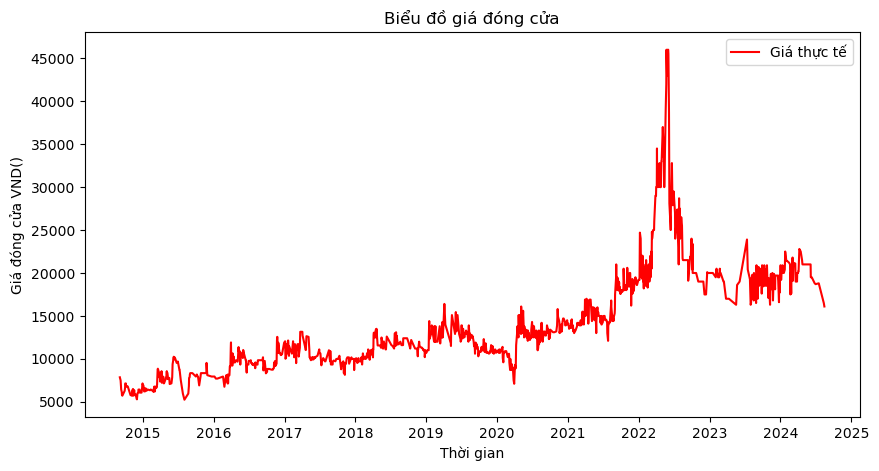

In [5]:
#Biểu đồ giá đóng cửa
plt.figure(figsize=(10,5))
plt.plot(df1['Price'], label='Giá thực tế',color='red')
plt.title("Biểu đồ giá đóng cửa")
plt.xlabel('Thời gian')
plt.ylabel("Giá đóng cửa VND()")
plt.legend()#Chú thích
plt.show()

In [6]:
#Chia tập dữ liệu
data=df1.values
train_data=data[:800]#1500 mẫu Đầu để huấn luyện
test_data=data[800:]#Các giá trị còn lại bao bao gồm khoảng 1000 mẫu để dữ đoán

In [7]:
#Chuẩn hóa dữ liệu điều chỉnh data coi giá trị nhỏ nhất nhất =0 lớn nhất =1 còn lại chạy từ 0->1
sc= MinMaxScaler(feature_range=(0,1))
sc_train=sc.fit_transform(data)

In [8]:
#Tạo vòng lặp các giá trị
#Mô hình sẽ sử dụng giá của 50 ngày liên tục làm cơ sở dự đoán cho giá của ngày tiếp theo
x_train,y_train=[],[]
for i in range(50,len(train_data)):
    x_train.append(sc_train[i-50:i,0])#dấu chia laf loc cắt từ i-50 đến i ví dụ i=50 [0:50]
    y_train.append(sc_train[i,0])


In [9]:
#Xếp dữ liệu thành 1 mảng để đưa vào mô hình
x_train = np.array(x_train)
y_train = np.array(y_train)
#Xếp dữ liệu thành mảng 1 chiều
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train=np.reshape(y_train,(y_train.shape[0], 1))

In [10]:
#Xây dựng mô hình
#Mô hình gồm 5 lớp 1 lớp đầu vào input 2 lớp LSTM 1 lớp Dropout 1 lớp output
model = Sequential()#Tạo lớp mạng cho dữ liệu đầu vào
model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))#Kết nối với đầu vào nên mô tả thông tin đầu vào = input shape
model.add(LSTM(units=64))
model.add(Dropout(0.5))# Giúp bỏ qua 1 số đơn vị trong quá trình huấn luyện 1 cách ngẫu nhiên tránh cho mô hình học tủ
model.add(Dense(1))# Lớp output Dense với đầu ra 1 chiều để dự đoán cho 1 giá trị
model.compile(loss='mean_absolute_error',optimizer='adam')# Hàm sai số loss sẽ đo sai số tuyệt đối trung bình , Trình tối ưu hóa adam giúp tối ưu hóa quá trình học

In [11]:
#Huấn luyện mô hình
save_model="save_model.hdf5"#Mô hình sau khi huấn luyện được lưu lại dưới dạng file save_model.hdf5
best_model=ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')# Sử dụng hàm ModelCheckpoint để tìm ra model được huấn luyện tốt nhất thêm vào save_model
model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.05019, saving model to save_model.hdf5
15/15 - 4s - loss: 0.0502 - 4s/epoch - 283ms/step
Epoch 2/100

Epoch 2: loss improved from 0.05019 to 0.02929, saving model to save_model.hdf5
15/15 - 1s - loss: 0.0293 - 1s/epoch - 69ms/step
Epoch 3/100

Epoch 3: loss improved from 0.02929 to 0.02586, saving model to save_model.hdf5
15/15 - 1s - loss: 0.0259 - 1s/epoch - 83ms/step
Epoch 4/100

Epoch 4: loss improved from 0.02586 to 0.02271, saving model to save_model.hdf5
15/15 - 1s - loss: 0.0227 - 1s/epoch - 72ms/step
Epoch 5/100

Epoch 5: loss improved from 0.02271 to 0.02266, saving model to save_model.hdf5
15/15 - 1s - loss: 0.0227 - 995ms/epoch - 66ms/step
Epoch 6/100

Epoch 6: loss did not improve from 0.02266
15/15 - 1s - loss: 0.0228 - 892ms/epoch - 59ms/step
Epoch 7/100

Epoch 7: loss improved from 0.02266 to 0.02200, saving model to save_model.hdf5
15/15 - 1s - loss: 0.0220 - 931ms/epoch - 62ms/step
Epoch 8/100

Epoch 8: loss improved f

In [12]:
#Dữ liệu train
#y_train= Giá thực
#y_train_predict= Giá dự đoán
y_train=sc.inverse_transform(y_train)# Giá thực
final_model=load_model('save_model.hdf5')
y_train_predict=final_model.predict(x_train)
y_train_predict=sc.inverse_transform(y_train_predict)#Giá dự đoán
#inverse_transform là để điều chỉnh dữ liệu về định dạng giá trị gốc do dữ liệu đang đc chuẩn hóa từ 0->1

24/24 [==============================] - 1s 22ms/step


In [13]:
#Xử lý dữ liệu trong tập test
test=df1[len(train_data)-50:].values
test=test.reshape(-1,1)
sc_test=sc.transform(test)
x_test=[]
for i in range(50, test.shape[0]):
    x_test.append(sc_test[i-50:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#Dữ liệu test
y_test=data[800:]# Giá thực
y_test_predict=final_model.predict(x_test)
y_test_predict=sc.inverse_transform(y_test_predict) #Giá dự đoán


14/14 [==============================] - 0s 27ms/step


C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_15584\3458972412.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_1['Dự đoán']=y_train_predict #Thêm dữ liệu
C:\Users\QUANGHONEY\AppData\Local\Temp\ipykernel_15584\3458972412.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_1['Dự đoán']=y_test_predict # Thêm dữ liệu


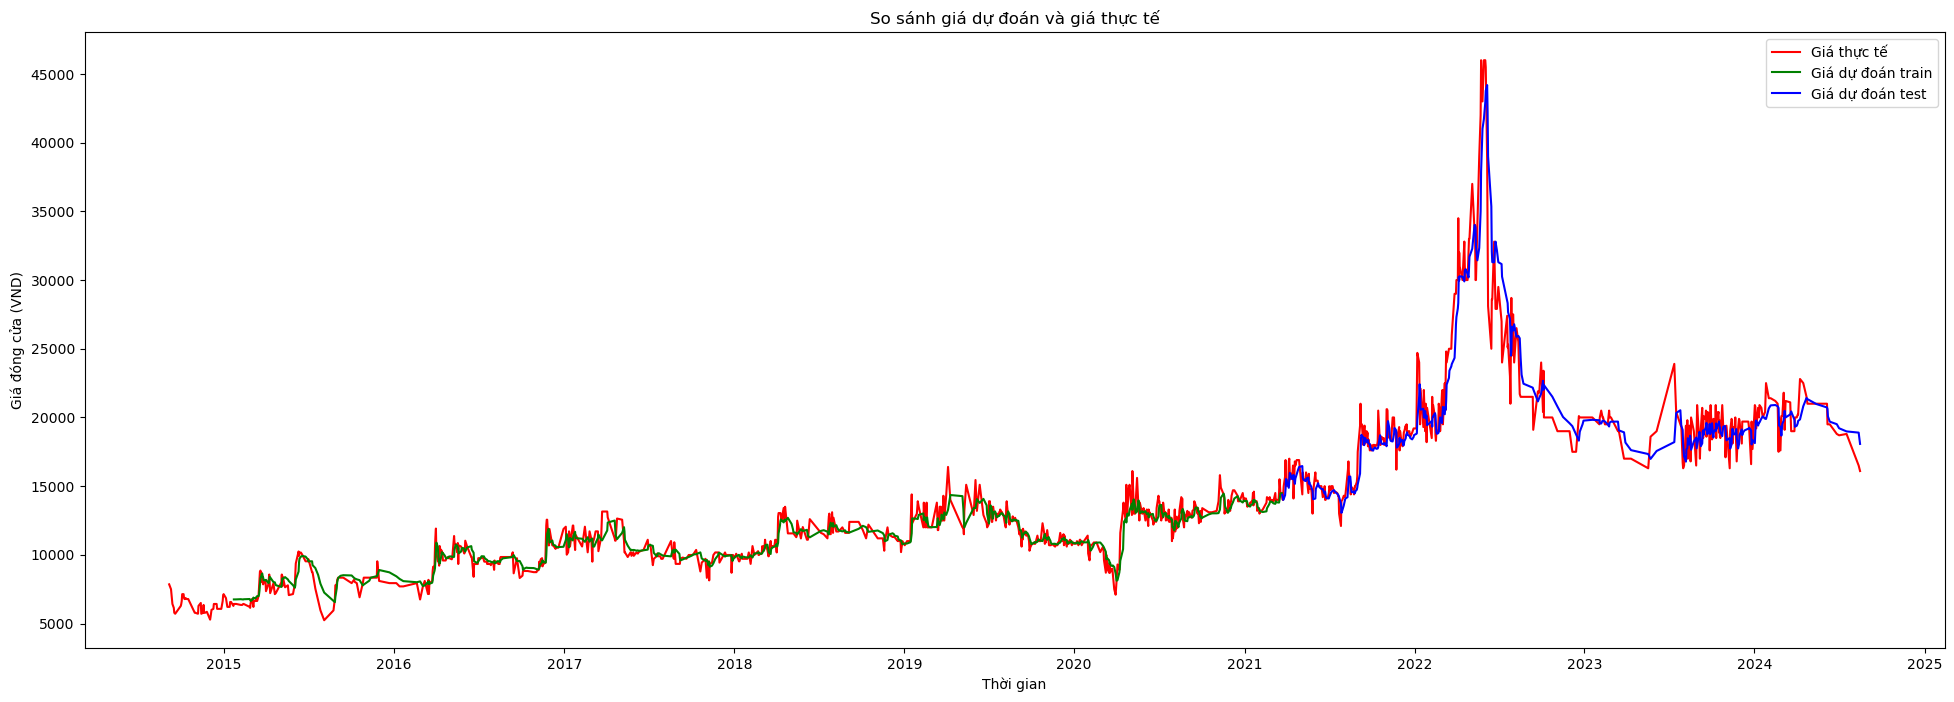

In [14]:
#7 Dùng biểu đồ để xem xét độ chính xác của mô hình
train_data_1=df1[50:800]
test_data_1=df1[800:]
plt.figure(figsize=(24,8))
plt.plot(df1,label="Giá thực tế",color='red')# Đường giá thực tế
train_data_1['Dự đoán']=y_train_predict #Thêm dữ liệu
plt.plot(train_data_1['Dự đoán'],label='Giá dự đoán train',color='green')# Đường giá dự báo trên tập train
test_data_1['Dự đoán']=y_test_predict # Thêm dữ liệu
plt.plot(test_data_1['Dự đoán'],label='Giá dự đoán test', color='blue')# Đường giá dự báo trên tập test
plt.title("So sánh giá dự đoán và giá thực tế") #Tên biểu đồ
plt.xlabel('Thời gian')# Đặt tên hàm x trục hoành
plt.ylabel('Giá đóng cửa (VND)')
plt.legend()# Chú giải biểu đồ
plt.show()

In [15]:
# Phù hợp train
print("Độ phù hợp tập train: ",r2_score(y_train,y_train_predict))
print("Sai số tuyệt đối trung bình tập train: ", mean_absolute_error(y_train,y_train_predict))
print("Phần trăm sai số tuyệt đối trung bình tập train: ", mean_absolute_percentage_error(y_train,y_train_predict))
train_data_1

Độ phù hợp tập train:  0.8746249917921044
Sai số tuyệt đối trung bình tập train:  492.79551562499995
Phần trăm sai số tuyệt đối trung bình tập train:  0.04544326997152954


,Price,Dự đoán
Date,,
2015-01-22,6426,6755.295898
2015-01-27,6426,6758.291016
2015-02-06,6355,6773.037109
2015-02-09,6355,6761.529785
2015-02-11,6426,6749.575684
...,...,...
2021-03-15,14000,13807.365234
2021-03-16,14500,13803.781250
2021-03-17,15500,13982.175781


In [16]:
#Phù hợp tập test
print("Độ phù hợp tập test: ", r2_score(y_test, y_test_predict))
print("Sai số tuyệt đối trung bình tập test: ", mean_absolute_error(y_test, y_test_predict))
print("Phần trăm sai số tuyệt đối trung bình tập test: ", mean_absolute_percentage_error(y_test, y_test_predict))
test_data_1

Độ phù hợp tập test:  0.871998215965613
Sai số tuyệt đối trung bình tập test:  1247.952268204599
Phần trăm sai số tuyệt đối trung bình tập test:  0.0577254877019277


,Price,Dự đoán
Date,,
2021-03-23,14200,14370.884766
2021-03-24,14000,14184.195312
2021-03-25,14500,13994.911133
2021-03-26,15000,14065.768555
2021-03-29,15700,14343.589844
...,...,...
2024-06-26,18800,19511.095703
2024-07-01,18700,19213.001953
2024-07-17,18800,18983.923828
